In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import math
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Read in CIFAR-100 dataset
import _pickle as cPickle
import numpy as np

#cifar_100_dir="C:\\Users\\talha\\Documents\\datasets\\cifar\\cifar-100-python\\"
cifar_100_dir="/home/talha/deeplearning/cifar100/cifar-100-python/"

def to_cifar_imgs(cifar_data_x):
    cifar_data_x = cifar_data_x.reshape([-1, 3, 32, 32])
    cifar_data_x = cifar_data_x.transpose([0, 2, 3, 1])
    return cifar_data_x.reshape([-1, 32*32*3])
    
def read_cifar_data(cifar_dir):
    cifar_train = cifar_dir+"train"
    cifar_test = cifar_dir+"test"
    
    # Read in train dataset
    with open(cifar_train, 'rb') as f:
        dic = cPickle.load(f, encoding='latin1') #need to set encoding because of pickle incompatability b/w Python 2 and Python 3
    train_x = np.asarray(dic['data'], dtype=np.float32)
    train_x = to_cifar_imgs(train_x)
    train_y = np.asarray(dic['fine_labels'])
    
    # Read in test dataset
    with open(cifar_test, 'rb') as f:
        dic = cPickle.load(f, encoding='latin1')
    test_x = np.asarray(dic['data'], dtype=np.float32)
    test_x = to_cifar_imgs(test_x)
    test_y = np.asarray(dic['fine_labels'])
    
    return (train_x, train_y, test_x, test_y)

(cifar_train_x, cifar_train_y, cifar_test_x, cifar_test_y) = read_cifar_data(cifar_100_dir)

In [3]:
print(cifar_train_x[9991])
cifar_train_x = (cifar_train_x - np.min(cifar_train_x, axis=1).reshape(cifar_train_x.shape[0],1)) / \
                (np.max(cifar_train_x, axis=1).reshape(cifar_train_x.shape[0],1))
print(cifar_train_x[9991])
cifar_test_x = (cifar_test_x - np.min(cifar_test_x, axis=1).reshape(cifar_test_x.shape[0],1)) / \
                (np.max(cifar_test_x, axis=1).reshape(cifar_test_x.shape[0],1))
a=1000
print(cifar_train_x[a:a+10])

[ 123.  112.   84. ...,   58.   75.   25.]
[ 0.48235294  0.43921569  0.32941177 ...,  0.22745098  0.29411766
  0.09803922]
[[ 0.62698412  0.51190478  0.4642857  ...,  0.61507934  0.57539684
   0.5674603 ]
 [ 0.09019608  0.22352941  0.51372552 ...,  0.03921569  0.50196081
   0.75294119]
 [ 1.          1.          1.         ...,  0.41960785  0.27058825
   0.1254902 ]
 ..., 
 [ 0.94117647  0.94117647  0.94117647 ...,  0.13725491  0.12156863
   0.10196079]
 [ 0.90118575  0.88142294  0.84980237 ...,  0.770751    0.75889325
   0.71936756]
 [ 0.13278009  0.14107884  0.07883818 ...,  0.45643154  0.40248963
   0.53526974]]


In [4]:
cifar100_model_config = {'input' : {'img_dims' : [32, 32, 3], 'size': 3072},
                      'output': {'num_classes' : 100},
                      'conv1' : {'filters' : 32, 'filter_size' : [3,3,3,32], 'stride' : [1,1,1,1], 'padding' : 'VALID'}, 
                      'conv2' : {'filters' : 64, 'filter_size' : [5,5,32,64], 'stride' : [1,1,1,1], 'padding' : 'VALID'},
                      'pool1' : {'filter_size' : [1,2,2,1], 'stride' : [1,2,2,1]},
                      'pool2' : {'filter_size' : [1,2,2,1], 'stride' : [1,2,2,1]},
                      'fc1' : {'in_size': 5*5*64, 'size' : 1024},
                      'fc2' : {'in_size': 1024, 'size' : 100}}

In [5]:
def plot_cifar_image(input_):
    plt.imshow(np.reshape(input_, (32, 32, 3)), cmap="gray")
    return plt

def plot_cifar_activations(activations):
    print ("Plotting conv layer outputs: ")
    filters = activations.shape[3] # get number of filters/activations
    plt.figure(1, figsize=(20,20)) 
    columns = 6
    rows = math.ceil(filters / columns) + 1
    for i in range(filters):
        plt.subplot(rows, columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(activations[0,:,:,i], interpolation="nearest")

def plot_cifar_filters(model_filters):
    """
    Plots only first covolution layer fitlers.
    """
    print ("Plotting Covolution Layer Filters: ")
    num_filters = model_filters.shape[3] # get number of filters/activations
    print (model_filters.shape)
    plt.figure(1, figsize=(20,20)) 
    columns = 6
    rows = math.ceil(num_filters / columns) + 1
    for i in range(num_filters):
        plt.subplot(rows, columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(model_filters[:,:,0,i], interpolation="nearest")


def get_weight(shape):
    weight = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(weight)

def get_bias(shape):
    bias = tf.constant(0.1, shape=shape)
    return tf.Variable(bias)

def conv2d(x, W, strides=[1,1,1,1], padding='VALID'):
    return tf.nn.conv2d(x, W, strides=strides, padding=padding)

def max_pool(x, kernel_size=[1, 2, 2, 1], strides=[1,2,2,1], padding='VALID'):
    return tf.nn.max_pool(x, ksize=kernel_size, strides=strides, padding=padding)


def init_model_weights(model_config):
    """
    Gets model configuration dictionary as a parameter and initializes the model weights
    @param model_config: a dictionary containing model configuration 
    @returns a dictionary containing initialized model weights
    """
    W_conv1 = get_weight(shape=model_config['conv1']['filter_size'])
    b_conv1 = get_bias([model_config['conv1']['filters']])

    W_conv2 = get_weight(shape=model_config['conv2']['filter_size'])
    b_conv2 = get_bias([model_config['conv2']['filters']])

    W_fc1 = get_weight(shape=[model_config['fc1']['in_size'], model_config['fc1']['size']])
    b_fc1 = get_bias([model_config['fc1']['size']])

    W_fc2 = get_weight(shape=[model_config['fc2']['in_size'], model_config['fc2']['size']])
    b_fc2 = get_bias([model_config['fc2']['size']])
    
    return {'W_conv1':W_conv1, 'b_conv1':b_conv1, 
            'W_conv2':W_conv2, 'b_conv2':b_conv2, 
            'W_fc1':W_fc1, 'b_fc1' : b_fc1,
            'W_fc2':W_fc2, 'b_fc2':b_fc2}


def cnn_model_for_cifar(x, model_config):
    """
    Defines a CNN model 
    @param model_config: a dictionary specifying model configuration
    @returns output of the logits layer
    """
    # initialize model weights
    model_weights = init_model_weights(model_config)
    
    # Reshape input images
    input_images = tf.reshape(x, np.concatenate(
                                    ([-1], model_config['input']['img_dims'])))
    
    # Conv 1
    conv1 = tf.nn.relu(conv2d(
                        x=input_images, W=model_weights['W_conv1'], 
                        strides= model_config['conv1']['stride']) + 
                       model_weights['b_conv1'])
    # Pool 1
    pool1 = max_pool(conv1, kernel_size=model_config['pool1']['filter_size'], 
                     strides=model_config['pool1']['stride'])

    # Conv 2
    conv2 = tf.nn.relu(conv2d(
                        x=pool1, W=model_weights['W_conv2'], 
                        strides=model_config['conv2']['stride']) + 
                       model_weights['b_conv2'])
    # Pool 2
    pool2 = max_pool(conv2, kernel_size=model_config['pool2']['filter_size'], 
                     strides=model_config['pool2']['stride'])

    # Flatten
    pool2_flat = tf.reshape(pool2, [-1, model_config['fc1']['in_size']])
    
    # FC Layer
    fc1 = tf.nn.relu(tf.matmul(pool2_flat, model_weights['W_fc1']) + model_weights['b_fc1'])
    
    #fc1_dropout = tf.nn.dropout(fc1, 0.7)
    
    # Logits
    logits = tf.matmul(fc1, model_weights['W_fc2']) + model_weights['b_fc2']
    
    return (conv1, conv2, fc1, logits, model_weights)

In [6]:
# Hyperparameters for training CNN on CIFAR-100 dataset
cifar100_batch_size = 64
cifar100_train_examples = cifar_train_x.shape[0]
cifar100_learning_rate=1e-3 
cifar_training_iterations =10001
beta=0.005


with tf.device('/cpu:0'):
    # Placholders for CIFAR-100 input
    cifar100_in = tf.placeholder(tf.float32, shape=[None, cifar100_model_config['input']['size']])
    cifar_100_labels = tf.placeholder(tf.float32, shape=[None, cifar100_model_config['output']['num_classes']])

    (cifar_conv1, cifar_conv2, cifar_fc1, cifar100_logits, cifar100_model_weights) = \
            cnn_model_for_cifar(cifar100_in, cifar100_model_config)

    #print (cifar100_learning_rate)
    # Define loss and optimizer
    cross_entropy_loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(labels=cifar_100_labels, logits=cifar100_logits))
    
    l2_regularizer = tf.nn.l2_loss(cifar100_model_weights['W_fc1'])
    loss = tf.reduce_mean(cross_entropy_loss + beta * l2_regularizer)
    
    train_op = tf.train.AdamOptimizer(cifar100_learning_rate).minimize(loss)
    correct_prediction = tf.equal(tf.argmax(cifar100_logits, 1), tf.argmax(cifar_100_labels, 1))
    cifar_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Initialize the variables
    init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

# Training cycle
avg_cost = 0.
avg_acc = 0.

for _iter in range(cifar_training_iterations):

    mask = np.random.choice(cifar100_train_examples, cifar100_batch_size)
    batch_x = cifar_train_x[mask]
    batch_y = tf.one_hot(cifar_train_y[mask], 
                                depth=cifar100_model_config['output']['num_classes']).eval(session=sess)
    
    # Run training step and cost op 
    t, c, a = sess.run(
                    [train_op, loss, cifar_accuracy], 
                    feed_dict={cifar100_in: batch_x, cifar_100_labels: batch_y}
                    )
    avg_cost+=c
    avg_acc+=a
       
    if _iter % 1000 == 0:
        print("Iterations: " + str(_iter) + ", cost = " + str(avg_cost/1000))  
        print("Iterations: " + str(_iter) + ", Training data accuracy = " + str(round(avg_acc/10, 4)) + "%")
        cifar_accuracy_ = sess.run(cifar_accuracy, feed_dict={cifar100_in: cifar_test_x,
                                         cifar_100_labels: tf.one_hot(
                                             cifar_test_y, depth=cifar100_model_config['output']['num_classes']).eval(session=sess)})
        print("Iterations = " + str(_iter) + ", Test data Accuracy = "  + str(round(cifar_accuracy_*100, 2)) + "%")
        print("==================================================\n")
        avg_cost=0
        avg_acc=0

Iterations: 0, cost = 0.0454670181274
Iterations: 0, Training data accuracy = 0.0%
Iterations = 0, Test data Accuracy = 0.99%

Iterations: 1000, cost = 8.91368529797
Iterations: 1000, Training data accuracy = 14.3406%
Iterations = 1000, Test data Accuracy = 19.52%

Iterations: 2000, cost = 3.46658109355
Iterations: 2000, Training data accuracy = 26.3547%
Iterations = 2000, Test data Accuracy = 26.87%

Iterations: 3000, cost = 3.13573474073
Iterations: 3000, Training data accuracy = 32.7891%
Iterations = 3000, Test data Accuracy = 29.84%

Iterations: 4000, cost = 2.97535280156
Iterations: 4000, Training data accuracy = 37.1594%
Iterations = 4000, Test data Accuracy = 32.91%

Iterations: 5000, cost = 2.82930764341
Iterations: 5000, Training data accuracy = 41.4016%
Iterations = 5000, Test data Accuracy = 33.46%

Iterations: 6000, cost = 2.72092200994
Iterations: 6000, Training data accuracy = 45.1344%
Iterations = 6000, Test data Accuracy = 35.24%

Iterations: 7000, cost = 2.61638064837


In [29]:
cifar_accuracy_ = sess.run(cifar_accuracy, feed_dict={cifar100_in: cifar_test_x,
                                         cifar_100_labels: tf.one_hot(
                                             cifar_test_y, depth=cifar100_model_config['output']['num_classes']).eval(session=sess)})

print("\nAccuracy: " + str(round(cifar_accuracy_*100, 2)) + "%")


Accuracy: 36.37%


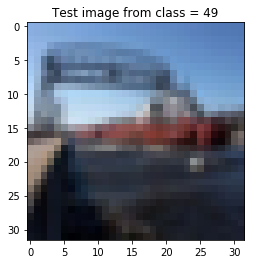

In [30]:
import random
cifar_selected_image_index = random.randint(0,1000)
cifar_selected_image = cifar_test_x[cifar_selected_image_index]
plot_cifar_image(cifar_selected_image)
plt.title("Test image from class = " + str(cifar_test_y[0]))

Plotting conv layer outputs: 


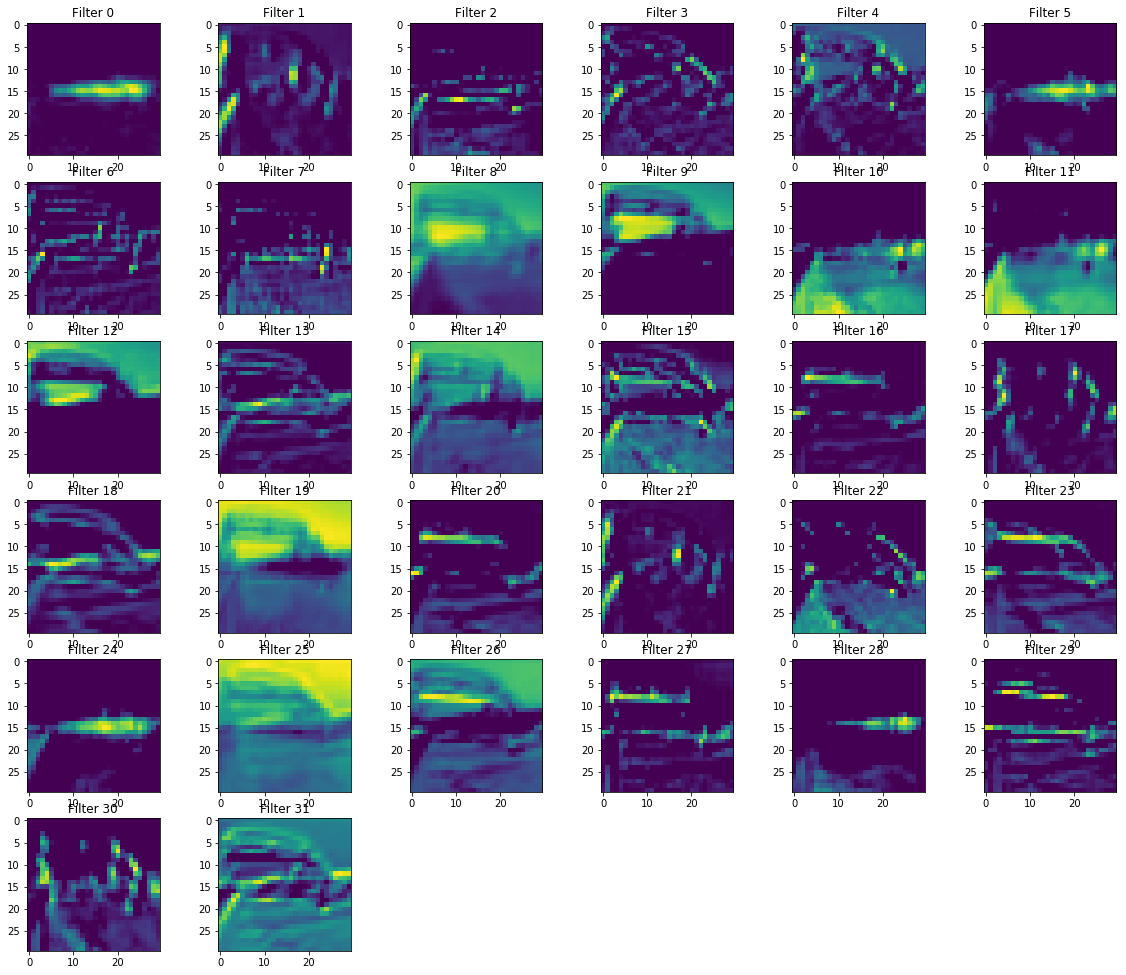

In [31]:
cifar_conv1_out = sess.run(cifar_conv1,feed_dict={cifar100_in:np.reshape(cifar_selected_image,[1,3072],order='F')})
plot_cifar_activations(cifar_conv1_out)

Plotting conv layer outputs: 


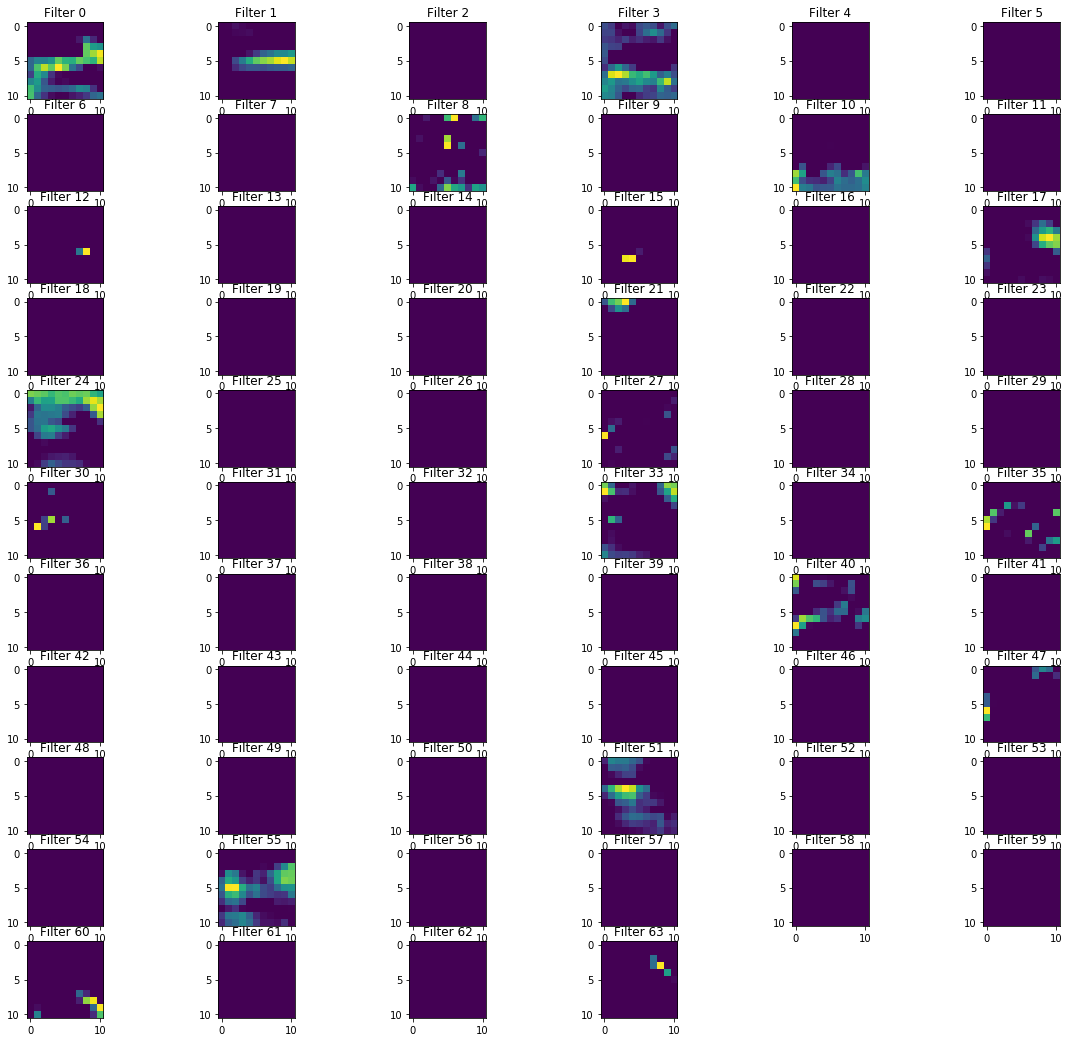

In [32]:
cifar_conv2_out = sess.run(cifar_conv2,feed_dict={cifar100_in:np.reshape(cifar_selected_image,[1,3072],order='F')})
plot_cifar_activations(cifar_conv2_out)

In [33]:
import random
cifar_starting_at = random.randint(0,100)
cifar_ending_at = cifar_starting_at + 9

cifar_to_test_images = cifar_test_x[cifar_starting_at:cifar_ending_at]
cifar_to_test_image_labels = cifar_test_y[cifar_starting_at:cifar_ending_at]
print(cifar_to_test_images.shape)

cifar_prediction = tf.nn.softmax(cifar100_logits)
cifar_pred = sess.run(cifar_prediction, feed_dict={cifar100_in: cifar_to_test_images,
                                         cifar_100_labels: tf.one_hot(cifar_to_test_image_labels, 
                                            depth=cifar100_model_config['output']['num_classes']).eval(session=sess)})

cifar_pred_class = tf.argmax(cifar_pred, 1)

print(cifar_to_test_image_labels)
cifar_model_predictions = cifar_pred_class.eval(session=sess)
print(cifar_model_predictions)

(9, 3072)
[43 92 97 70 53 70 49 75 29]
[43 92 97 70 70 70 39 48 96]


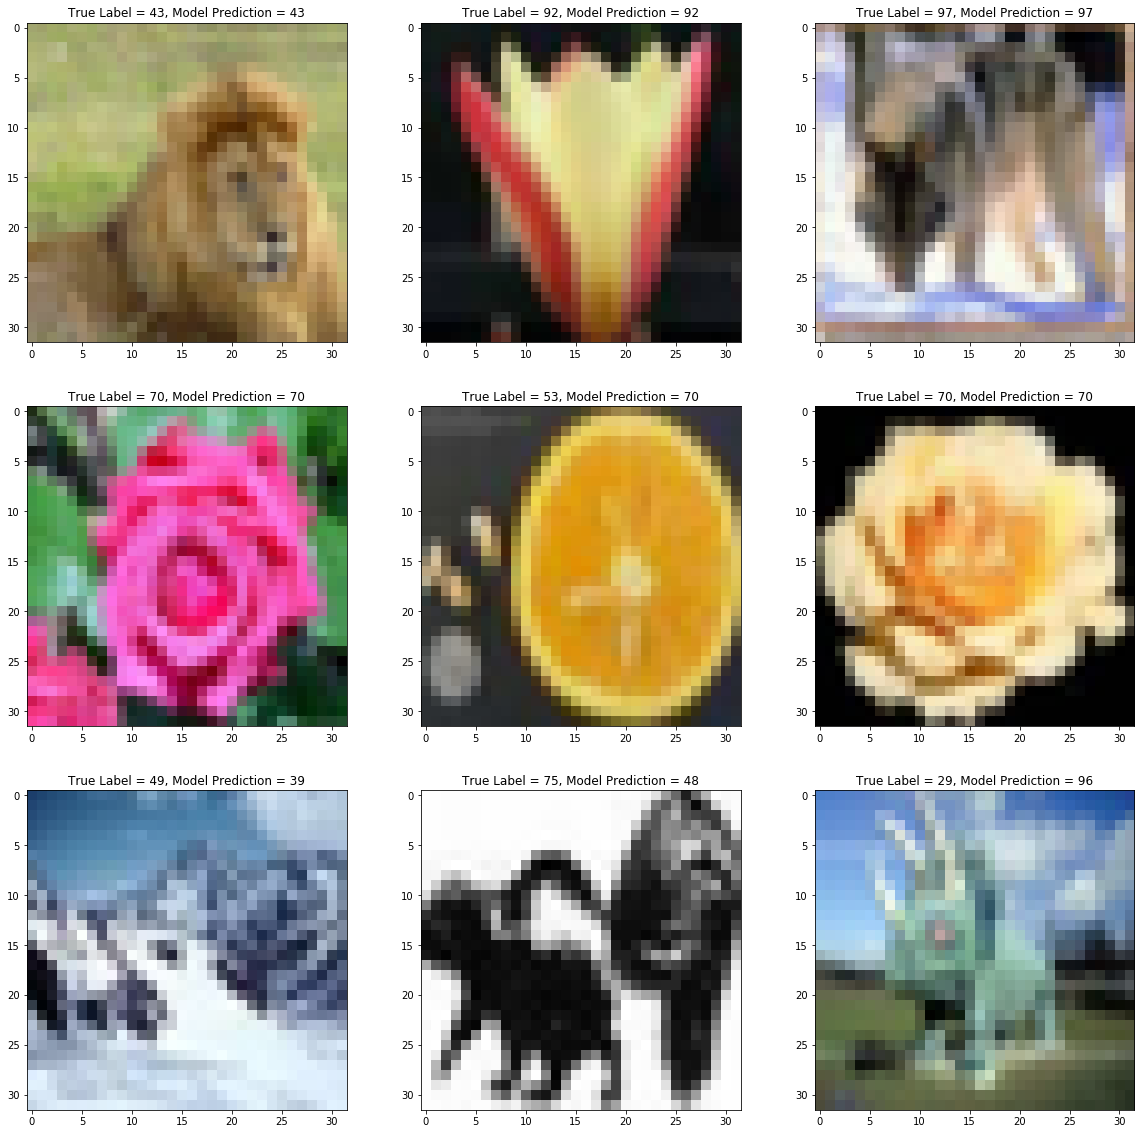

In [34]:
plt.figure(1, figsize=(20,20))
cifar_imgs = np.reshape(cifar_to_test_images, (9,32,32,3))
rows = 3
columns = 3
for i in range(9):
    plt.subplot(rows, columns, i+1)
    plt.title("True Label = " + str(cifar_to_test_image_labels[i]) + 
              ", Model Prediction = " + str(cifar_model_predictions[i]))
    plt.imshow(cifar_imgs[i,:,:], cmap="gray")

Plotting Covolution Layer Filters: 
(3, 3, 3, 32)


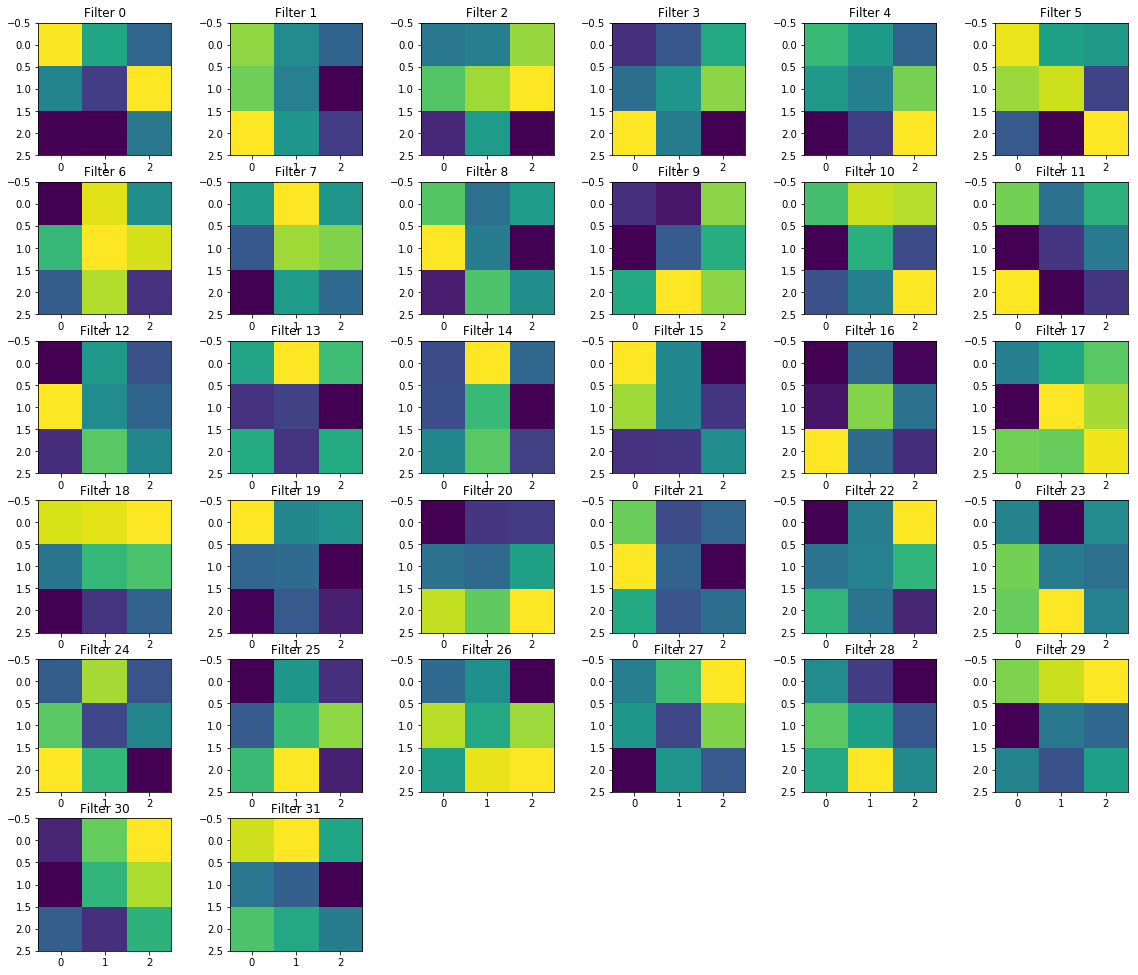

In [35]:
plot_cifar_filters(cifar100_model_weights['W_conv1'].eval(session=sess))

Plotting Covolution Layer Filters: 
(5, 5, 32, 32)


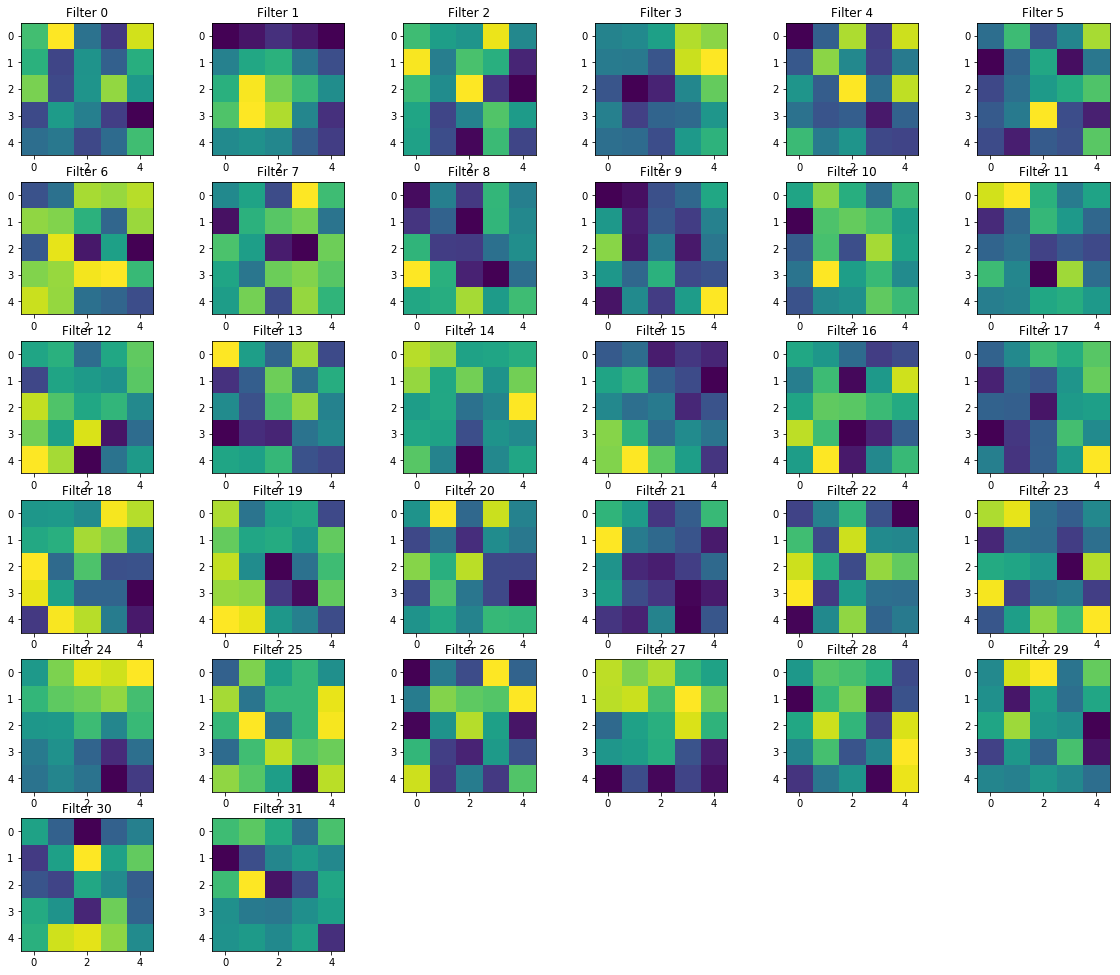

In [36]:
plot_cifar_filters(tf.reshape(cifar100_model_weights['W_conv2'].eval(session=sess)[:,:,:,np.arange(0,32)], [5,5,32,32]).eval(session=sess))

In [37]:
sess.close()